In [1]:
# libraries

import re
from pathlib import Path
import pandas as pd
import numpy as np
from joblib import load, dump
import json, shutil
import ast


import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import Isomap
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.model_selection import GroupKFold, cross_validate

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from joblib import dump




In [2]:
# Cell 1 — Data audit & schema snapshot (MAIN files only)


BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

FILES = {
    "player_match_ccfc": "player_match_stats_ccfc.csv",
    "player_match_lcfc": "player_match_stats_lcfc.csv",
    "team_match_stats": "team_match_stats.csv",
    "matches_info_ccfc": "matches_info_ccfc.csv",
    "matches_info_lcfc": "matches_info_lcfc.csv",
    "physical_player_match": "physical_player_match_stats.csv",
    "player_season_stats": "player_season_stats.csv",
}

print("Data dir:", DATA_DIR.resolve())
print({k: (DATA_DIR / v).exists() for k, v in FILES.items()})

def to_snake(s: str) -> str:
    s = s.strip().replace("/", "_").replace("-", "_")
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"__+", "_", s)
    return s.lower()

def safe_preview_csv(path: Path, nrows=50):
    """Try a few encodings; return (df, encoding_used)."""
    for enc in [None, "utf-8", "latin1", "utf-16"]:
        try:
            df = pd.read_csv(path, nrows=nrows, low_memory=False, encoding=enc)
            return df, (enc or "default")
        except UnicodeDecodeError:
            continue
        except Exception as e:
            try:
                df = pd.read_csv(path, nrows=nrows, low_memory=False, encoding=enc, engine="python")
                return df, (enc or "default (python engine)")
            except Exception:
                continue
    raise RuntimeError(f"Could not read {path.name} with common encodings.")

schema = {}
for key, fname in FILES.items():
    fpath = DATA_DIR / fname
    if not fpath.exists():
        schema[key] = {"error": f"Missing file: {fname}"}
        print(f"[MISSING] {fname}")
        continue

    df, enc = safe_preview_csv(fpath, nrows=200)
    original_cols = list(df.columns)
    df.columns = [to_snake(c) for c in df.columns]

    out_head = OUTPUT_DIR / f"HEAD_{key}.csv"
    df.head(50).to_csv(out_head, index=False)

    schema[key] = {
        "file": fname,
        "encoding_used": enc,
        "columns_count": len(df.columns),
        "columns": list(df.columns),
        "sample_rows_saved_to": str(out_head),
    }

with open(OUTPUT_DIR / "schema_snapshot.json", "w", encoding="utf-8") as f:
    json.dump(schema, f, indent=2)

print("\nWrote outputs/schema_snapshot.json")
print("First-50-row previews: outputs/HEAD_*.csv")


Data dir: C:\Users\rahma\OneDrive - MMU\Semester-2\Msc Project\player_prediction\Rahmath_Mozumder_20050347\data
{'player_match_ccfc': True, 'player_match_lcfc': True, 'team_match_stats': True, 'matches_info_ccfc': True, 'matches_info_lcfc': True, 'physical_player_match': True, 'player_season_stats': True}

Wrote outputs/schema_snapshot.json
First-50-row previews: outputs/HEAD_*.csv


In [5]:
# Cell 2 — Aggregate player-match → player-season (with season join via matches_info)

ccfc_path = DATA_DIR / FILES["player_match_ccfc"]
lcfc_path = DATA_DIR / FILES["player_match_lcfc"]
mi_ccfc   = DATA_DIR / FILES["matches_info_ccfc"]
mi_lcfc   = DATA_DIR / FILES["matches_info_lcfc"]

def load_matches_info(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    df.columns = [c.strip().lower() for c in df.columns]
    if "season" not in df.columns:
        # derive from date if needed
        if "match_date" in df.columns:
            d = pd.to_datetime(df["match_date"], errors="coerce")
            df["season"] = np.where(d.dt.month >= 7, d.dt.year, d.dt.year - 1)
        else:
            raise KeyError(f"'season' not found and no 'match_date' in {path.name}")
    return df[["match_id","season"]].dropna()

mi = pd.concat([load_matches_info(mi_ccfc), load_matches_info(mi_lcfc)], ignore_index=True)
mi = mi.drop_duplicates("match_id")
print("matches_info map:", mi.shape)

AGG_CANDIDATES = [
    "player_match_minutes",
    "player_match_goals", "player_match_assists",
    "player_match_key_passes",
    "player_match_np_shots", "player_match_np_shots_on_target",
    # add more if confirm they exist:
    # "player_match_shots", "player_match_yellow_cards", "player_match_red_cards",
]
MODE_CANDIDATES = ["player_name", "team_id", "team_name"]

def mode_or_first(s: pd.Series):
    try:
        m = s.mode(dropna=True)
        if not m.empty:
            return m.iloc[0]
    except Exception:
        pass
    s2 = s.dropna()
    return s2.iloc[0] if len(s2) else np.nan


def season_rollup_with_season_merge(path: Path, mi_map: pd.DataFrame, chunksize=250_000) -> pd.DataFrame:
    acc = []
    usecols = None 
    for chunk in pd.read_csv(path, chunksize=chunksize, low_memory=False):
        chunk.columns = [c.strip().lower() for c in chunk.columns]
        for col in ["player_id", "match_id"]:
            if col not in chunk.columns:
                raise KeyError(f"'{col}' missing in {path.name}")
        chunk = chunk.merge(mi_map, on="match_id", how="left")
        if "season" not in chunk.columns:
            raise KeyError("Failed to attach 'season' from matches_info — check match_id consistency")
        present_sum  = [c for c in AGG_CANDIDATES if c in chunk.columns]
        present_mode = [c for c in MODE_CANDIDATES if c in chunk.columns]

        keep = ["player_id", "season"] + present_sum + present_mode
        df = chunk[keep]

        g = df.groupby(["player_id","season"]).agg({
            **{c: "sum" for c in present_sum},
            **{c: mode_or_first for c in present_mode}
        }).reset_index()
        acc.append(g)

    combined = pd.concat(acc, ignore_index=True)
    final = combined.groupby(["player_id","season"]).agg({
        **{c: "sum" for c in [c for c in AGG_CANDIDATES if c in combined.columns]},
        **{c: mode_or_first for c in [c for c in MODE_CANDIDATES if c in combined.columns]}
    }).reset_index()
    return final

print("Aggregating CCFC...")
players_ccfc = season_rollup_with_season_merge(ccfc_path, mi)
print("Aggregating LCFC...")
players_lcfc = season_rollup_with_season_merge(lcfc_path, mi)

players_season = pd.concat([players_ccfc, players_lcfc], ignore_index=True)

if "player_match_minutes" in players_season.columns:
    mins = players_season["player_match_minutes"].replace(0, np.nan)
    for col in ["player_match_goals","player_match_assists","player_match_np_shots","player_match_key_passes","player_match_np_shots_on_target"]:
        if col in players_season.columns:
            players_season[col.replace("player_match_", "") + "_per90"] = players_season[col] / (mins / 90)

out_path = OUTPUT_DIR / "players_season.parquet"
players_season.to_parquet(out_path, index=False)
print("Saved:", out_path.resolve(), "shape:", players_season.shape)

players_season.head()


matches_info map: (66856, 2)
Aggregating CCFC...
Aggregating LCFC...
Saved: C:\Users\rahma\OneDrive - MMU\Semester-2\Msc Project\player_prediction\Rahmath_Mozumder_20050347\outputs\players_season.parquet shape: (163718, 16)


,player_id,season,player_match_minutes,player_match_goals,player_match_assists,player_match_key_passes,player_match_np_shots,player_match_np_shots_on_target,player_name,team_id,team_name,goals_per90,assists_per90,np_shots_per90,key_passes_per90,np_shots_on_target_per90
0,2933,"{'season_id': 108, 'season_name': '2021/2022'}",872.666678,1,1,6,15,3,Myziane Maolida,136,Hertha Berlin,0.103132,0.103132,1.546982,0.618793,0.309396
1,2933,"{'season_id': 235, 'season_name': '2022/2023'}",371.883331,1,0,3,6,2,Myziane Maolida,156,Hertha Berlin,0.242011,0.000000,1.452068,0.726034,0.484023
2,2933,"{'season_id': 281, 'season_name': '2023/2024'}",1515.016677,10,2,19,48,20,Myziane Maolida,884,Hibernian,0.594053,0.118811,2.851454,1.128700,1.188106
3,2933,"{'season_id': 42, 'season_name': '2019/2020'}",743.516665,1,2,13,16,5,Myziane Maolida,136,OGC Nice,0.121046,0.242093,1.936742,1.573603,0.605232
4,2933,"{'season_id': 90, 'season_name': '2020/2021'}",1137.716661,3,1,15,19,4,Myziane Maolida,136,OGC Nice,0.237317,0.079106,1.503010,1.186587,0.316423


In [6]:
# Cell 2b — Flatten season column

df = pd.read_parquet(OUTPUT_DIR / "players_season.parquet")

if df["season"].astype(str).str.startswith("{").any():
    def unpack_season(val):
        try:
            d = ast.literal_eval(str(val))
            return pd.Series({"season_id": d.get("season_id"), "season_name": d.get("season_name")})
        except Exception:
            return pd.Series({"season_id": None, "season_name": None})

    season_expanded = df["season"].apply(unpack_season)
    df = pd.concat([df.drop(columns=["season"]), season_expanded], axis=1)

clean_path = OUTPUT_DIR / "players_season_clean.parquet"
df.to_parquet(clean_path, index=False)
print("Saved cleaned dataset:", clean_path, "shape:", df.shape)

df.head()


Saved cleaned dataset: c:\Users\rahma\OneDrive - MMU\Semester-2\Msc Project\player_prediction\Rahmath_Mozumder_20050347\outputs\players_season_clean.parquet shape: (163718, 17)


,player_id,player_match_minutes,player_match_goals,player_match_assists,player_match_key_passes,player_match_np_shots,player_match_np_shots_on_target,player_name,team_id,team_name,goals_per90,assists_per90,np_shots_per90,key_passes_per90,np_shots_on_target_per90,season_id,season_name
0,2933,872.666678,1,1,6,15,3,Myziane Maolida,136,Hertha Berlin,0.103132,0.103132,1.546982,0.618793,0.309396,108,2021/2022
1,2933,371.883331,1,0,3,6,2,Myziane Maolida,156,Hertha Berlin,0.242011,0.000000,1.452068,0.726034,0.484023,235,2022/2023
2,2933,1515.016677,10,2,19,48,20,Myziane Maolida,884,Hibernian,0.594053,0.118811,2.851454,1.128700,1.188106,281,2023/2024
3,2933,743.516665,1,2,13,16,5,Myziane Maolida,136,OGC Nice,0.121046,0.242093,1.936742,1.573603,0.605232,42,2019/2020
4,2933,1137.716661,3,1,15,19,4,Myziane Maolida,136,OGC Nice,0.237317,0.079106,1.503010,1.186587,0.316423,90,2020/2021


In [7]:
# Cell 3 — Enrich players_season (physical, team context, positions)

PS_BASE = OUTPUT_DIR / "players_season_clean.parquet"
if not PS_BASE.exists():
    PS_BASE = OUTPUT_DIR / "players_season.parquet"

def to_snake(s: str) -> str:
    s = s.strip().replace("/", "_").replace("-", "_")
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"__+", "_", s)
    return s.lower()

def read_csv_any(path: Path):
    for enc in [None, "utf-8", "latin1", "utf-16"]:
        try:
            df = pd.read_csv(path, low_memory=False, encoding=enc)
            df.columns = [to_snake(c) for c in df.columns]
            return df
        except UnicodeDecodeError:
            continue
    raise RuntimeError(f"Could not read {path.name} with common encodings")

def ensure_season_id(df: pd.DataFrame, matches_map: pd.DataFrame, date_cols=("match_date","date","game_date")):
    """Return df with a season_id column. If not present, derive via join on match_id; else from date."""
    out = df.copy()
    cols = set(out.columns)
    if "season_id" in cols:
        return out
    if "season" in cols and pd.api.types.is_integer_dtype(out["season"]):
        out = out.rename(columns={"season": "season_id"})
        return out
    if "match_id" in cols and "season_id" in matches_map.columns:
        out = out.merge(matches_map[["match_id","season_id"]], on="match_id", how="left")
        return out
    for dc in date_cols:
        if dc in cols:
            d = pd.to_datetime(out[dc], errors="coerce")
            out["season_id"] = np.where(d.dt.month >= 7, d.dt.year, d.dt.year - 1)
            return out
    raise KeyError("Could not determine season_id — no season/match_id/date available")


players_season = pd.read_parquet(PS_BASE)
players_season.columns = [to_snake(c) for c in players_season.columns]


id_cols = [c for c in ["player_id","team_id","season_id","season_name"] if c in players_season.columns]
assert "player_id" in players_season.columns, "player_id missing in players_season"
assert "season_id" in players_season.columns, "season_id missing (run Step 2b)"


mi_ccfc = read_csv_any(DATA_DIR / FILES["matches_info_ccfc"])
mi_lcfc = read_csv_any(DATA_DIR / FILES["matches_info_lcfc"])
mi_all = pd.concat([mi_ccfc, mi_lcfc], ignore_index=True)
mi_all = ensure_season_id(mi_all, mi_all) 
mi_map = mi_all[["match_id","season_id"]].dropna().drop_duplicates()


phys_path = DATA_DIR / FILES["physical_player_match"]
phys_season = None
if phys_path.exists():
    phys = read_csv_any(phys_path)
    phys = ensure_season_id(phys, mi_map)

    drop_non_num = {"player_id","player_name","match_id","team_id","team_name","season_id","season_name","competition_id","competition_name"}
    num_cols = [c for c in phys.columns if c not in drop_non_num and pd.api.types.is_numeric_dtype(phys[c])]

    if num_cols:
        g = phys.groupby(["player_id","season_id"])[num_cols].agg(["sum","mean"]).reset_index()
        g.columns = ["player_id","season_id"] + [f"phys_{lvl2}_{lvl1}" for lvl1, lvl2 in g.columns.to_list()[2:]]
        phys_season = g
        players_season = players_season.merge(phys_season, on=["player_id","season_id"], how="left")

tms_path = DATA_DIR / FILES["team_match_stats"]
if tms_path.exists() and "team_id" in players_season.columns:
    tms = read_csv_any(tms_path)
    tms = ensure_season_id(tms, mi_map)


    drop_ids = {"team_id","team_name","opposition_id","opposition_name","match_id","account_id","season_id","season_name","competition_id","competition_name"}
    team_num = [c for c in tms.columns if c not in drop_ids and pd.api.types.is_numeric_dtype(tms[c])]
    if team_num:
        team_season = tms.groupby(["team_id","season_id"])[team_num].mean().reset_index()
        rename_map = {c: f"teamctx_{c}" for c in team_num}
        team_season = team_season.rename(columns=rename_map)
        if "team_id" in players_season.columns:
            players_season = players_season.merge(team_season, on=["team_id","season_id"], how="left")

pss_path = DATA_DIR / FILES["player_season_stats"]
if pss_path.exists():
    pss = read_csv_any(pss_path)
    pss = ensure_season_id(pss, mi_map)
    
    pos_cols = [c for c in ["primary_position","secondary_position","preferred_foot"] if c in pss.columns]
    keep_cols = ["player_id","season_id"] + pos_cols
    pss_small = pss[keep_cols].drop_duplicates(subset=["player_id","season_id"])
    players_season = players_season.merge(pss_small, on=["player_id","season_id"], how="left")

ENH = OUTPUT_DIR / "players_season_enhanced.parquet"
players_season.to_parquet(ENH, index=False)
print("Saved:", ENH.resolve(), "shape:", players_season.shape)

players_season.head()



Saved: C:\Users\rahma\OneDrive - MMU\Semester-2\Msc Project\player_prediction\Rahmath_Mozumder_20050347\outputs\players_season_enhanced.parquet shape: (163718, 231)


,player_id,player_match_minutes,player_match_goals,player_match_assists,player_match_key_passes,player_match_np_shots,player_match_np_shots_on_target,player_name,team_id,team_name,...,teamctx_team_match_obv_dribble_carry_conceded,teamctx_team_match_obv_gk_conceded,teamctx_team_match_passes,teamctx_team_match_successful_passes,teamctx_team_match_passes_conceded,teamctx_team_match_successful_passes_conceded,teamctx_team_match_op_passes,teamctx_team_match_op_passes_conceded,primary_position,secondary_position
0,2933,872.666678,1,1,6,15,3,Myziane Maolida,136,Hertha Berlin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2933,371.883331,1,0,3,6,2,Myziane Maolida,156,Hertha Berlin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2933,1515.016677,10,2,19,48,20,Myziane Maolida,884,Hibernian,...,0.737264,-0.003356,471.078947,362.868421,424.973684,316.842105,417.684211,377.684211,Left Wing,Centre Forward
3,2933,743.516665,1,2,13,16,5,Myziane Maolida,136,OGC Nice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2933,1137.716661,3,1,15,19,4,Myziane Maolida,136,OGC Nice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Cell 3b — Diagnostics on players_season_enhanced

ENH = OUTPUT_DIR / "players_season_enhanced.parquet"
df = pd.read_parquet(ENH)

n_players = df["player_id"].nunique()
n_seasons = df["season_id"].nunique()
print(f"players: {n_players:,} | seasons: {n_seasons:,} | rows: {len(df):,}")


sample_names = df["player_name"].dropna().drop_duplicates().head(20).tolist()
print("sample player names:", sample_names)


teamctx_cols = [c for c in df.columns if c.startswith("teamctx_")]
if teamctx_cols:
    teamctx_nonnull_rows = df[teamctx_cols].notna().any(axis=1).sum()
    print(f"team context coverage: {teamctx_nonnull_rows:,}/{len(df):,} "
          f"({teamctx_nonnull_rows/len(df)*100:.1f}%) have at least one teamctx value")
else:
    print("No teamctx_ columns found (skip)")

if teamctx_cols:
    cov_by_season = (
        df.assign(_has_teamctx=df[teamctx_cols].notna().any(axis=1))
          .groupby("season_id")["_has_teamctx"].mean().mul(100).round(1)
          .sort_index()
    )
    print("teamctx coverage by season_id (%):")
    print(cov_by_season.to_string())

tms = pd.read_csv(DATA_DIR / FILES["team_match_stats"], low_memory=False)
tms.columns = [re.sub(r"\s+","_",c.strip().lower()) for c in tms.columns]
if "team_id" in tms.columns:
    known_teams = set(tms["team_id"].unique())
    missing_team_rows = (~df["team_id"].isin(known_teams)).sum()
    print(f"Rows with team_id not found in team_match_stats: {missing_team_rows:,}/{len(df):,} "
          f"({missing_team_rows/len(df)*100:.1f}%)")


players: 38,079 | seasons: 13 | rows: 163,718
sample player names: ['Myziane Maolida', 'Nordi Mukiele', 'Christophe Kerbrat', 'Faitout Maouassa', 'Ihsan Nino Sacko', 'Jean Eudès Aholou', 'Ismaïla Sarr', 'Adama Mbengue', 'Lucas Deaux', 'Benjamin Corgnet', 'Frédéric Guilbert', 'Anthony Lopes', 'Nabil Fekir', 'Fernando Marçal', 'Jonas Martin', 'Marnick Vermijl', 'Yoann Salmier', 'Youri Tielemans', 'Ronny Rodelin', 'Bertrand Traoré']
team context coverage: 26,832/163,718 (16.4%) have at least one teamctx value
teamctx coverage by season_id (%):
season_id
30      0.0
42      0.0
43     16.8
90     12.5
91      0.0
106    27.1
107    27.7
108    12.3
235    21.9
281    23.7
282    23.6
315     0.0
317    23.8
Rows with team_id not found in team_match_stats: 123,975/163,718 (75.7%)


In [9]:
# Cell 4 — Build supervised dataset (season t → predict minutes in t+1)

ENH = OUTPUT_DIR / "players_season_enhanced.parquet"
assert ENH.exists(), "players_season_enhanced.parquet missing — run Step 3 first."

df = pd.read_parquet(ENH).copy()

required = ["player_id", "season_id", "player_match_minutes"]
for c in required:
    if c not in df.columns:
        raise KeyError(f"Required column missing: {c}")


df["player_match_minutes"] = pd.to_numeric(df["player_match_minutes"], errors="coerce")

per90_cols = [c for c in df.columns if c.endswith("_per90")]

phys_mean_cols = [c for c in df.columns if c.startswith("phys_mean_")]

teamctx_keep = [
    "teamctx_team_match_np_xg",
    "teamctx_team_match_np_xg_conceded",
    "teamctx_team_match_possession",
    "teamctx_team_match_ppda",
]
teamctx_cols = [c for c in teamctx_keep if c in df.columns]

core_raw = [c for c in [
    "player_match_minutes",
    "player_match_goals",
    "player_match_assists",
    "player_match_key_passes",
    "player_match_np_shots",
    "player_match_np_shots_on_target",
] if c in df.columns]

pos_col = "primary_position" if "primary_position" in df.columns else None
if pos_col:
    pos_dummies = pd.get_dummies(df[pos_col].fillna("Unknown"), prefix="pos", dtype="int8")
else:
    pos_dummies = pd.DataFrame(index=df.index)

feature_candidates = core_raw + per90_cols + phys_mean_cols + teamctx_cols

feature_candidates = [c for i, c in enumerate(feature_candidates) if c in df.columns and c not in feature_candidates[:i]]


def add_lags(frame: pd.DataFrame, cols: list, lags=(1, 2)):
    out = frame.sort_values(["player_id", "season_id"]).copy()
    for c in cols:
        if c in out.columns:
            for L in lags:
                out[f"{c}_lag{L}"] = out.groupby("player_id")[c].shift(L)
    return out


lag_base = ["player_match_minutes"] + per90_cols + phys_mean_cols[:8]
df_lag = add_lags(df, lag_base, lags=(1, 2))

df_lag["target_minutes_next_season"] = df_lag.groupby("player_id")["player_match_minutes"].shift(-1)


id_cols = ["player_id", "season_id"]
X_cols = feature_candidates + [f"{c}_lag1" for c in lag_base if f"{c}_lag1" in df_lag.columns] + \
                         [f"{c}_lag2" for c in lag_base if f"{c}_lag2" in df_lag.columns]


X = df_lag[id_cols + X_cols].copy()
if not pos_dummies.empty:
    X = pd.concat([X, pos_dummies], axis=1)


sup = X.copy()
sup["target_minutes_next_season"] = df_lag["target_minutes_next_season"]


sup = sup.dropna(subset=["target_minutes_next_season"]).reset_index(drop=True)


sup = sup.replace([np.inf, -np.inf], np.nan)

SUP_PATH = OUTPUT_DIR / "supervised_dataset.parquet"
sup.to_parquet(SUP_PATH, index=False)

feature_list = [c for c in sup.columns if c not in (id_cols + ["target_minutes_next_season"])]
with open(OUTPUT_DIR / "feature_list.json", "w") as f:
    json.dump(feature_list, f, indent=2)

print(f"Saved supervised dataset -> {SUP_PATH}")
print(f"Rows: {len(sup):,} | Features: {len(feature_list)} (plus IDs)")
print("Example columns:", feature_list[:20])
sup.head(3)


Saved supervised dataset -> c:\Users\rahma\OneDrive - MMU\Semester-2\Msc Project\player_prediction\Rahmath_Mozumder_20050347\outputs\supervised_dataset.parquet
Rows: 125,639 | Features: 89 (plus IDs)
Example columns: ['player_match_minutes', 'player_match_goals', 'player_match_assists', 'player_match_key_passes', 'player_match_np_shots', 'player_match_np_shots_on_target', 'goals_per90', 'assists_per90', 'np_shots_per90', 'key_passes_per90', 'np_shots_on_target_per90', 'phys_mean_competition_edition_id', 'phys_mean_minutes_full_all', 'phys_mean_physical_check_passed', 'phys_mean_total_distance_full_all', 'phys_mean_total_metersperminute_full_all', 'phys_mean_running_distance_full_all', 'phys_mean_hsr_distance_full_all', 'phys_mean_hsr_count_full_all', 'phys_mean_sprint_distance_full_all']


,player_id,season_id,player_match_minutes,player_match_goals,player_match_assists,player_match_key_passes,player_match_np_shots,player_match_np_shots_on_target,goals_per90,assists_per90,...,pos_Right Back,pos_Right Centre Back,pos_Right Centre Forward,pos_Right Centre Midfielder,pos_Right Defensive Midfielder,pos_Right Midfielder,pos_Right Wing,pos_Right Wing Back,pos_Unknown,target_minutes_next_season
0,2933,42,743.516665,1,2,13,16,5,0.121046,0.242093,...,0,0,0,0,0,0,0,0,1,1137.716661
1,2933,90,1137.716661,3,1,15,19,4,0.237317,0.079106,...,0,0,0,0,0,0,0,0,1,872.666678
2,2933,108,872.666678,1,1,6,15,3,0.103132,0.103132,...,0,0,0,0,0,0,0,0,1,835.750010


In [10]:
# Cell 5 — Model training & evaluation (temporal split + GroupKFold CV)

SUP_PATH = OUTPUT_DIR / "supervised_dataset.parquet"
assert SUP_PATH.exists(), f"Missing {SUP_PATH} — run Step 4 first."
MODEL_DIR = OUTPUT_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

sup = pd.read_parquet(SUP_PATH).copy()

ID_COLS = ["player_id", "season_id"]
TARGET = "target_minutes_next_season"
assert all(c in sup.columns for c in ID_COLS + [TARGET]), "Required columns missing."

feature_cols = [c for c in sup.columns if c not in ID_COLS + [TARGET]]

cutoff = int(np.nanpercentile(sup["season_id"].values, 80))
train_df = sup[sup["season_id"] <= cutoff].copy()
test_df  = sup[sup["season_id"]  > cutoff].copy()

print(f"Temporal split — cutoff season_id = {cutoff}")
print(f"Train rows: {len(train_df):,} | Test rows: {len(test_df):,}")

X_train = train_df[feature_cols].values
y_train = train_df[TARGET].astype(float).values
X_test  = test_df[feature_cols].values
y_test  = test_df[TARGET].astype(float).values
groups  = train_df["player_id"].values  

def pipe(est):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", est),
    ])

models = {
    "Mean baseline": None, 
    "LinearRegression": pipe(LinearRegression()),
    "Ridge(alpha=1.0)": pipe(Ridge(alpha=1.0, random_state=42)),
    "RandomForest": pipe(RandomForestRegressor(
        n_estimators=400, max_depth=None, n_jobs=-1, random_state=42
    )),
    "GradientBoosting": pipe(GradientBoostingRegressor(random_state=42)),
    "HistGradientBoosting": pipe(HistGradientBoostingRegressor(random_state=42)),
}

def cv_scores(estimator, X, y, groups, cv_splits=5):
    cv = GroupKFold(n_splits=cv_splits)
    scoring = {
        "mae":  "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error",
        "r2":   "r2",
    }
    res = cross_validate(estimator, X, y, cv=cv.split(X, y, groups),
                         scoring=scoring, n_jobs=-1, return_train_score=False)
    return {
        "CV_MAE":  -res["test_mae"].mean(),
        "CV_RMSE": -res["test_rmse"].mean(),
        "CV_R2":    res["test_r2"].mean(),
    }


results = []
fitted  = {}


mean_pred = np.full_like(y_test, fill_value=np.mean(y_train), dtype=float)
results.append({
    "Model": "Mean baseline",
    "CV_MAE":  np.nan, "CV_RMSE": np.nan, "CV_R2": np.nan,
    "Test_MAE": mean_absolute_error(y_test, mean_pred),
    "Test_RMSE": mean_squared_error(y_test, mean_pred, squared=False),
    "Test_R2": r2_score(y_test, mean_pred),
})

for name, est in models.items():
    if est is None: 
        continue
    cv_out = cv_scores(est, X_train, y_train, groups, cv_splits=5)
    est.fit(X_train, y_train)
    y_hat = est.predict(X_test)
    test_mae  = mean_absolute_error(y_test, y_hat)
    test_rmse = mean_squared_error(y_test, y_hat, squared=False)
    test_r2   = r2_score(y_test, y_hat)
    results.append({
        "Model": name, **cv_out,
        "Test_MAE": test_mae, "Test_RMSE": test_rmse, "Test_R2": test_r2
    })
    fitted[name] = est


res_df = pd.DataFrame(results).sort_values("Test_MAE").reset_index(drop=True)
print("\n=== Evaluation (lower is better for MAE/RMSE) ===")
print(res_df)

METRICS_CSV = OUTPUT_DIR / "metrics_table.csv"
res_df.to_csv(METRICS_CSV, index=False)
best_name = res_df.iloc[0]["Model"]
summary = {
    "cutoff_season_id": int(cutoff),
    "n_train": int(len(train_df)),
    "n_test": int(len(test_df)),
    "best_model": best_name,
}
with open(OUTPUT_DIR / "metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print(f"\nSaved metrics table -> {METRICS_CSV}")
print(f"Saved summary       -> {OUTPUT_DIR / 'metrics_summary.json'}")


best_estimator = fitted.get(best_name)
if best_estimator is not None:
    MODEL_PATH = MODEL_DIR / "best_minutes_model.joblib"
    dump(best_estimator, MODEL_PATH)
    print(f"Saved best model    -> {MODEL_PATH}")
else:
    print("Best is the mean baseline — no model artifact saved.")


Temporal split — cutoff season_id = 281
Train rows: 113,986 | Test rows: 11,653


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 42 43 44
 45 46 47 48 49 56 57 58 59 60 61 62 63]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 42 43 44
 45 46 47 48 49 56 57 58 59 60 61 62 63]. At least one non-missing value is needed for imputation 


=== Evaluation (lower is better for MAE/RMSE) ===
                  Model      CV_MAE     CV_RMSE     CV_R2    Test_MAE  \
0  HistGradientBoosting  569.739143  765.581431  0.458055  437.156419   
1          RandomForest  575.769353  786.043215  0.428679  445.033790   
2      GradientBoosting  585.820311  774.457032  0.445417  470.891728   
3      Ridge(alpha=1.0)  598.324144  789.827313  0.423180  481.375920   
4      LinearRegression  598.326968  789.828674  0.423178  481.390664   
5         Mean baseline         NaN         NaN       NaN  857.827475   

    Test_RMSE   Test_R2  
0  652.611847  0.420251  
1  675.093050  0.379621  
2  666.469591  0.395369  
3  680.052841  0.370472  
4  680.061170  0.370456  
5  967.623603 -0.274509  

Saved metrics table -> c:\Users\rahma\OneDrive - MMU\Semester-2\Msc Project\player_prediction\Rahmath_Mozumder_20050347\outputs\metrics_table.csv
Saved summary       -> c:\Users\rahma\OneDrive - MMU\Semester-2\Msc Project\player_prediction\Rahmath_Mozumd

c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 42 43 44
 45 46 47 48 49 56 57 58 59 60 61 62 63]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
# Cell 5b — Choose best model and update Streamlit artifacts

# Paths
OUTPUT_DIR = Path("outputs")
MODEL_DIR  = OUTPUT_DIR / "models"
SUP_PATH   = OUTPUT_DIR / "supervised_dataset.parquet"
ENH_PATH   = OUTPUT_DIR / "players_season_enhanced.parquet"

candidates = []
for p in [OUTPUT_DIR / "metrics_table.csv", OUTPUT_DIR / "metrics_table_improved.csv"]:
    if p.exists():
        df = pd.read_csv(p)
        df["_source_metrics"] = p.name
        candidates.append(df)
if not candidates:
    raise FileNotFoundError("No metrics_table*.csv found in outputs/. Run Cell 5/5+ first.")

metrics = pd.concat(candidates, ignore_index=True)

for col in ["Model","Test_MAE","Test_RMSE","Test_R2"]:
    assert col in metrics.columns, f"Missing column in metrics: {col}"


metrics["_rank_tuple"] = list(zip(metrics["Test_MAE"], metrics["Test_RMSE"], -metrics["Test_R2"]))
best_row = metrics.sort_values("_rank_tuple", ascending=True).iloc[0].to_dict()

print("=== Model selection ===")
print(f"Chosen: {best_row['Model']}  | Test MAE={best_row['Test_MAE']:.1f}, "
      f"RMSE={best_row['Test_RMSE']:.1f}, R²={best_row['Test_R2']:.3f} "
      f"({best_row['_source_metrics']})")

artifact_map = {
    "HistGradientBoosting": MODEL_DIR / "best_minutes_model.joblib",            
    "HistGradientBoostingRegressor": MODEL_DIR / "best_minutes_model.joblib",   
    "HGB_tuned": MODEL_DIR / "best_minutes_model_tuned.joblib",                 
    "Ensemble_avg": MODEL_DIR / "best_minutes_model_tuned.joblib",              
    "HGB_per_position": MODEL_DIR / "best_minutes_model_tuned.joblib",          
    "RandomForest": MODEL_DIR / "best_minutes_model.joblib",
    "GradientBoosting": MODEL_DIR / "best_minutes_model.joblib",
    "LinearRegression": MODEL_DIR / "best_minutes_model.joblib",
    "Ridge(alpha=1.0)": MODEL_DIR / "best_minutes_model.joblib",
    "Mean baseline": None,
}

model_name = str(best_row["Model"])
artifact_src = artifact_map.get(model_name)
if artifact_src is None or not artifact_src.exists():
    tuned = MODEL_DIR / "best_minutes_model_tuned.joblib"
    base  = MODEL_DIR / "best_minutes_model.joblib"
    artifact_src = tuned if tuned.exists() else base
    print(f"Note: picking available artifact -> {artifact_src.name}")

app_model_path = MODEL_DIR / "best_minutes_model.joblib"
if artifact_src != app_model_path:
    shutil.copy2(artifact_src, app_model_path)
print(f"App model set -> {app_model_path}")



sup = pd.read_parquet(SUP_PATH)
enh = pd.read_parquet(ENH_PATH)[["player_id","season_id","team_id","team_name","primary_position"]].drop_duplicates()

ID_COLS = ["player_id","season_id"]
TARGET = "target_minutes_next_season"
feat_cols = [c for c in sup.columns if c not in ID_COLS + [TARGET]]

model = load(app_model_path)
X_all = sup[feat_cols].values
pred_all = model.predict(X_all)

pred = sup[ID_COLS].copy()
pred["pred_minutes_t_plus_1"] = pred_all
pred["actual_minutes_t_plus_1"] = sup[TARGET].values
pred = pred.merge(enh, on=ID_COLS, how="left")

pred_path = OUTPUT_DIR / "predictions.parquet"
pred.to_parquet(pred_path, index=False)
print(f"Rebuilt predictions -> {pred_path}")

sel_summary = {
    "chosen_model": model_name,
    "source_metrics_file": best_row["_source_metrics"],
    "Test_MAE": float(best_row["Test_MAE"]),
    "Test_RMSE": float(best_row["Test_RMSE"]),
    "Test_R2": float(best_row["Test_R2"]),
}
with open(OUTPUT_DIR / "model_selection_summary.json", "w") as f:
    json.dump(sel_summary, f, indent=2)
print("Saved -> outputs/model_selection_summary.json")


=== Model selection ===
Chosen: HistGradientBoosting  | Test MAE=437.2, RMSE=652.6, R²=0.420 (metrics_table.csv)
App model set -> outputs\models\best_minutes_model.joblib
Rebuilt predictions -> outputs\predictions.parquet
Saved -> outputs/model_selection_summary.json


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 42 43 44
 45 46 47 48 49 56 57 58 59 60 61 62 63]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 42 43 44
 45 46 47 48 49 56 57 58 59 60 61 62 63]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


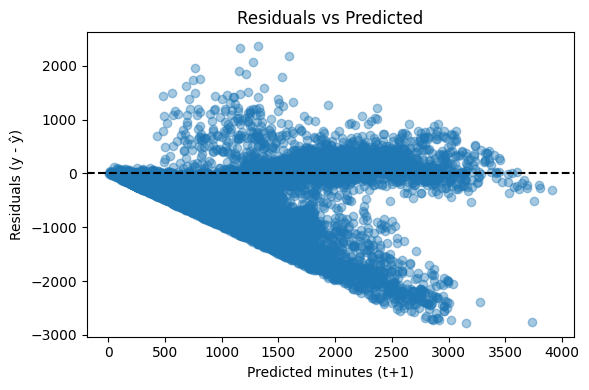

Saved residuals plot -> outputs\residuals.png
Model does not expose feature_importances_. Skipping.


In [12]:
# Cell 6 — Diagnostics: residual plot & feature importances (saved as PNGs)

SUP_PATH = OUTPUT_DIR / "supervised_dataset.parquet"
MODEL_PATH = OUTPUT_DIR / "models" / "best_minutes_model.joblib"

sup = pd.read_parquet(SUP_PATH)
ID_COLS = ["player_id", "season_id"]
TARGET = "target_minutes_next_season"
feature_cols = [c for c in sup.columns if c not in ID_COLS + [TARGET]]


cutoff = int(np.nanpercentile(sup["season_id"].values, 80))
test_df = sup[sup["season_id"] > cutoff].copy()
X_test  = test_df[feature_cols].values
y_test  = test_df[TARGET].astype(float).values

if MODEL_PATH.exists():
    model = load(MODEL_PATH)
    y_hat = model.predict(X_test)

    plt.figure(figsize=(6,4))
    plt.scatter(y_hat, y_test - y_hat, alpha=0.4)
    plt.axhline(0, linestyle="--", color="black")
    plt.xlabel("Predicted minutes (t+1)")
    plt.ylabel("Residuals (y - ŷ)")
    plt.title("Residuals vs Predicted")
    plt.tight_layout()
    RES_PATH = OUTPUT_DIR / "residuals.png"
    plt.savefig(RES_PATH, dpi=300)
    plt.show()
    print(f"Saved residuals plot -> {RES_PATH}")

    
    if hasattr(model.named_steps["model"], "feature_importances_"):
        importances = model.named_steps["model"].feature_importances_
        order = np.argsort(importances)[::-1][:25]  # top 25
        plt.figure(figsize=(7,8))
        plt.barh(np.array(feature_cols)[order][::-1], importances[order][::-1])
        plt.title("Top 25 Feature Importances")
        plt.tight_layout()
        FI_PATH = OUTPUT_DIR / "feature_importance.png"
        plt.savefig(FI_PATH, dpi=300)
        plt.show()
        print(f"Saved feature importance plot -> {FI_PATH}")
    else:
        print("Model does not expose feature_importances_. Skipping.")
else:
    print("No saved model found. Run Cell 5 first (ensure best model is not baseline).")


In [13]:
# Cell 7 — Polynomial Regression baseline

SUP_PATH = OUTPUT_DIR / "supervised_dataset.parquet"
sup = pd.read_parquet(SUP_PATH)

ID_COLS = ["player_id", "season_id"]
TARGET = "target_minutes_next_season"


poly_features = [
    "player_match_minutes",
    "goals_per90",
    "assists_per90",
    "np_shots_per90",
    "key_passes_per90",
]


sup_poly = sup.dropna(subset=poly_features + [TARGET]).copy()


cutoff = int(np.nanpercentile(sup_poly["season_id"].values, 80))
train_df = sup_poly[sup_poly["season_id"] <= cutoff]
test_df  = sup_poly[sup_poly["season_id"]  > cutoff]

X_train = train_df[poly_features].values
y_train = train_df[TARGET].values
X_test  = test_df[poly_features].values
y_test  = test_df[TARGET].values


poly_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])


poly_reg.fit(X_train, y_train)


y_hat = poly_reg.predict(X_test)


mae  = mean_absolute_error(y_test, y_hat)
rmse = mean_squared_error(y_test, y_hat, squared=False)
r2   = r2_score(y_test, y_hat)

print("\n=== Polynomial Regression (degree 2) ===")
print(f"Test MAE : {mae:,.1f}")
print(f"Test RMSE: {rmse:,.1f}")
print(f"Test R²  : {r2:,.3f}")


poly_results = pd.DataFrame([{
    "Model": "PolynomialRegression_deg2",
    "Test_MAE": mae,
    "Test_RMSE": rmse,
    "Test_R2": r2,
}])

POLY_METRICS = OUTPUT_DIR / "metrics_table.csv"
if POLY_METRICS.exists():
    all_results = pd.read_csv(POLY_METRICS)
    all_results = pd.concat([all_results, poly_results], ignore_index=True)
    all_results.to_csv(POLY_METRICS, index=False)
    print(f"Appended Polynomial Regression results -> {POLY_METRICS}")
else:
    poly_results.to_csv(POLY_METRICS, index=False)
    print(f"Saved Polynomial Regression results -> {POLY_METRICS}")



=== Polynomial Regression (degree 2) ===
Test MAE : 506.8
Test RMSE: 696.9
Test R²  : 0.339
Appended Polynomial Regression results -> outputs\metrics_table.csv


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['phys_mean_competition_edition_id' 'phys_mean_minutes_full_all'
 'phys_mean_physical_check_passed' 'phys_mean_total_distance_full_all'
 'phys_mean_total_metersperminute_full_all'
 'phys_mean_running_distance_full_all' 'phys_mean_hsr_distance_full_all'
 'phys_mean_hsr_count_full_all' 'phys_mean_sprint_distance_full_all'
 'phys_mean_sprint_count_full_all' 'phys_mean_hi_distance_full_all'
 'phys_mean_hi_count_full_all' 'phys_mean_medaccel_count_full_all'
 'phys_mean_highaccel_count_full_all' 'phys_mean_meddecel_count_full_all'
 'phys_mean_highdecel_count_full_all'
 'phys_mean_explacceltohsr_count_full_all' 'phys_mean_timetohsr'
 'phys_mean_explacceltosprint_count_full_all' 'phys_mean_timetosprint'
 'phys_mean_psv99' 'phys_mean_competition_edition_id_lag1'
 'phys_mean_minutes_full_all_lag1' 'phys_mean_physical_check_passed_lag1'


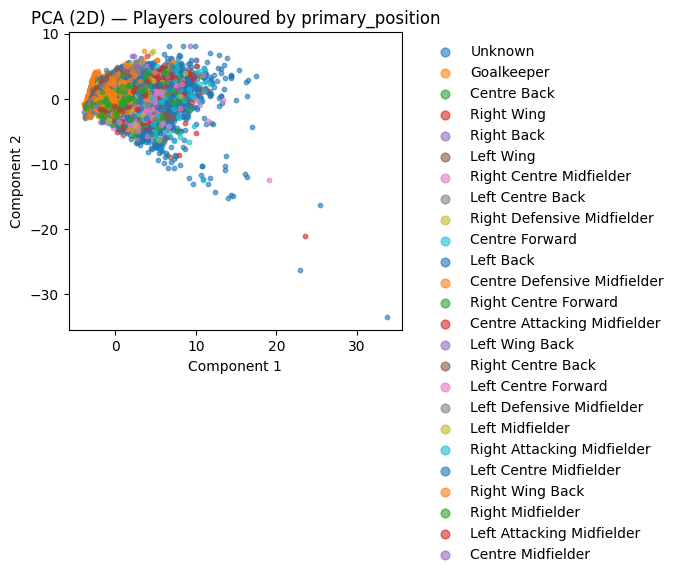

Saved -> outputs\pca_plot.png


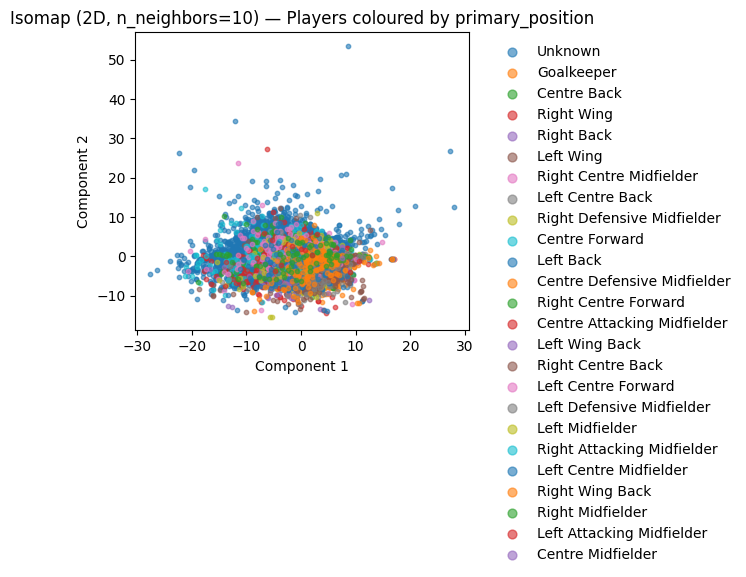

Saved -> outputs\isomap_plot.png
PCA explained variance ratio: [0.266, 0.114] (sum=0.381)


In [14]:
# Cell 8 — Dimensionality Reduction (PCA & Isomap) with position-colored plots

SUP_PATH = OUTPUT_DIR / "supervised_dataset.parquet"
ENH_PATH = OUTPUT_DIR / "players_season_enhanced.parquet"
assert SUP_PATH.exists(), "Missing supervised_dataset.parquet (run Step 4)."
assert ENH_PATH.exists(), "Missing players_season_enhanced.parquet (run Step 3)."


sup = pd.read_parquet(SUP_PATH)
enh = pd.read_parquet(ENH_PATH)[["player_id","season_id","primary_position"]]


sup_lab = sup.merge(enh, on=["player_id","season_id"], how="left")
sup_lab["primary_position"] = sup_lab["primary_position"].fillna("Unknown")


ID_COLS = ["player_id","season_id"]
TARGET = "target_minutes_next_season"


feature_cols = [c for c in sup_lab.columns
                if c not in ID_COLS + [TARGET, "primary_position"]
                and not c.startswith("pos_")]

X = sup_lab[feature_cols].copy()
y_pos = sup_lab["primary_position"].copy()


SAMPLE_N = 20_000
if len(X) > SAMPLE_N:
    samp_idx = np.random.RandomState(42).choice(len(X), size=SAMPLE_N, replace=False)
    X = X.iloc[samp_idx]
    y_pos = y_pos.iloc[samp_idx]


imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler(with_mean=True, with_std=True)
X_imp   = imputer.fit_transform(X)
X_std   = scaler.fit_transform(X_imp)


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)


iso = Isomap(n_neighbors=10, n_components=2)
X_iso = iso.fit_transform(X_std)

def _scatter_2d(Z, labels, title, save_path):
    plt.figure(figsize=(7,5))
    
    for pos in pd.unique(labels):
        m = (labels == pos)
        plt.scatter(Z[m,0], Z[m,1], s=10, alpha=0.6, label=pos)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1, frameon=False)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved -> {save_path}")

# ---- plots
_pca_path = OUTPUT_DIR / "pca_plot.png"
_scatter_title = "PCA (2D) — Players coloured by primary_position"
_scatter_title2 = "Isomap (2D, n_neighbors=10) — Players coloured by primary_position"

_scatter_positions = y_pos.astype(str).values
_scatter_Z = X_pca
_scatter_Z2 = X_iso

_scatter_fn = _scatter_2d
_scatter_fn(_scatter_Z,  _scatter_positions, _scatter_title,  _pca_path)

_iso_path = OUTPUT_DIR / "isomap_plot.png"
_scatter_fn(_scatter_Z2, _scatter_positions, _scatter_title2, _iso_path)


print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.round(3).tolist()}",
      f"(sum={pca.explained_variance_ratio_.sum():.3f})")


Clustering: kept 52 feature columns with data out of 89
Shapes — X: (125639, 52) | meta: (125639, 5)
Chosen k = 4 (silhouette on sample = 0.327)
Saved clusters -> outputs\clusters.parquet
Saved summary  -> outputs\cluster_summary.csv


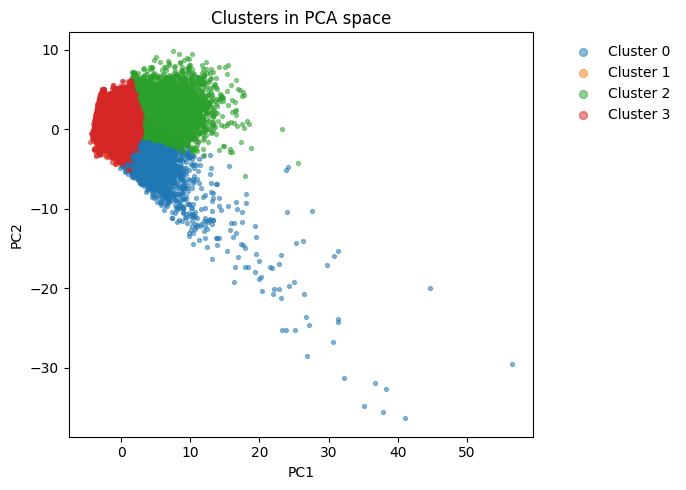

Saved plot -> outputs\cluster_plot.png


In [15]:
# Cell 9 — Robust clustering

SUP_PATH = OUTPUT_DIR / "supervised_dataset.parquet"
ENH_PATH = OUTPUT_DIR / "players_season_enhanced.parquet"
sup = pd.read_parquet(SUP_PATH).copy()
enh = pd.read_parquet(ENH_PATH)[["player_id","season_id","player_name","team_name","primary_position"]]

ID_COLS = ["player_id","season_id"]
TARGET = "target_minutes_next_season"
feature_cols = [c for c in sup.columns if c not in ID_COLS + [TARGET]]

X = sup[feature_cols].copy()

nonnull_counts = X.notna().sum(axis=0)
dense_cols = nonnull_counts[nonnull_counts > 0].index.tolist()
X = X[dense_cols]
print(f"Clustering: kept {X.shape[1]} feature columns with data out of {len(feature_cols)}")

fallback = [
    "player_match_minutes","goals_per90","assists_per90",
    "np_shots_per90","key_passes_per90",
    "player_match_minutes_lag1","player_match_minutes_lag2"
]
fallback = [c for c in fallback if c in sup.columns]
if X.shape[1] < 2:
    print("Too few usable columns; falling back to compact feature set:", fallback)
    X = sup[fallback].copy()


row_nonnull = X.notna().sum(axis=1) > 0
X = X.loc[row_nonnull]


enh_dedup = (
    enh.sort_values(["player_id","season_id"])
       .drop_duplicates(subset=["player_id","season_id"], keep="first")
)


meta = (
    sup.loc[row_nonnull, ID_COLS]
       .merge(enh_dedup, on=ID_COLS, how="left", validate="many_to_one")
       .reset_index(drop=True)
)

print("Shapes — X:", X.shape, "| meta:", meta.shape)
assert len(meta) == len(X), "Length mismatch after merge."


imp = SimpleImputer(strategy="median")
scaler = StandardScaler()
X_imp = imp.fit_transform(X)
X_std = scaler.fit_transform(X_imp)

n_comp = min(20, X_std.shape[1]) if X_std.shape[1] >= 2 else 2
pca = PCA(n_components=n_comp, random_state=42)
X_pca = pca.fit_transform(X_std)

N = len(X_pca)
if N < 50:
    raise ValueError(f"Not enough rows for clustering after filtering (N={N}).")

rng = np.random.RandomState(42)
sample_n = min(20000, N)
sample_idx = rng.choice(N, size=sample_n, replace=False)

best_k, best_s = 6, -1
for k in range(4, 11):
    km_tmp = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca[sample_idx])
    if len(np.unique(km_tmp.labels_)) > 1 and sample_n > k:
        s = silhouette_score(X_pca[sample_idx], km_tmp.labels_)
        if s > best_s:
            best_k, best_s = k, s

print(f"Chosen k = {best_k} (silhouette on sample = {best_s:.3f})")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_pca)
labels = kmeans.labels_

clusters = meta.copy()
clusters["cluster"] = labels
clusters["pc1"] = X_pca[:, 0]
clusters["pc2"] = X_pca[:, 1]

keep_for_summary = [
    "player_match_minutes","goals_per90","assists_per90",
    "np_shots_per90","key_passes_per90"
]
keep_for_summary = [c for c in keep_for_summary if c in sup.columns]
summary = clusters.join(
    sup[ID_COLS + keep_for_summary].set_index(ID_COLS),
    on=ID_COLS
)
cluster_summary = summary.groupby("cluster")[keep_for_summary].mean().round(2)
cluster_counts = summary["cluster"].value_counts().sort_index()
cluster_summary.insert(0, "count", cluster_counts.values)

CLUST_PATH = OUTPUT_DIR / "clusters.parquet"
clusters.to_parquet(CLUST_PATH, index=False)
CLUST_SUMMARY = OUTPUT_DIR / "cluster_summary.csv"
cluster_summary.to_csv(CLUST_SUMMARY)
print(f"Saved clusters -> {CLUST_PATH}")
print(f"Saved summary  -> {CLUST_SUMMARY}")

plt.figure(figsize=(7,5))
for c in sorted(clusters["cluster"].unique()):
    m = clusters["cluster"] == c
    plt.scatter(clusters.loc[m, "pc1"], clusters.loc[m, "pc2"], s=8, alpha=0.5, label=f"Cluster {c}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Clusters in PCA space")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
plt.tight_layout()
PLOT_PATH = OUTPUT_DIR / "cluster_plot.png"
plt.savefig(PLOT_PATH, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved plot -> {PLOT_PATH}")


In [16]:
# Cell 10 — Batch predictions for all player-seasons (t -> ŷ(t+1))

SUP_PATH = OUTPUT_DIR / "supervised_dataset.parquet"
ENH_PATH = OUTPUT_DIR / "players_season_enhanced.parquet"
MODEL_PATH = OUTPUT_DIR / "models" / "best_minutes_model.joblib"

sup = pd.read_parquet(SUP_PATH).copy()
enh = pd.read_parquet(ENH_PATH)[["player_id","season_id","player_name","team_name","primary_position"]]

ID_COLS = ["player_id","season_id"]
TARGET = "target_minutes_next_season"
feature_cols = [c for c in sup.columns if c not in ID_COLS + [TARGET]]

if not MODEL_PATH.exists():
    raise FileNotFoundError("Best model not found — run Cell 5.")

model = load(MODEL_PATH)


X_all = sup[feature_cols].values
y_hat_all = model.predict(X_all)

pred = sup[ID_COLS].copy()
pred["pred_minutes_t_plus_1"] = y_hat_all
pred["actual_minutes_t_plus_1"] = sup[TARGET].values

pred = pred.merge(enh, on=ID_COLS, how="left")

OUT = OUTPUT_DIR / "predictions.parquet"
pred.to_parquet(OUT, index=False)
print(f"Saved predictions -> {OUT}")
pred.head()


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 42 43 44
 45 46 47 48 49 56 57 58 59 60 61 62 63]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Saved predictions -> outputs\predictions.parquet


,player_id,season_id,pred_minutes_t_plus_1,actual_minutes_t_plus_1,player_name,team_name,primary_position
0,2933,42,935.841536,1137.716661,Myziane Maolida,OGC Nice,None
1,2933,90,1247.704971,872.666678,Myziane Maolida,OGC Nice,None
2,2933,108,981.408080,835.750010,Myziane Maolida,Hertha Berlin,None
3,2933,108,981.408080,835.750010,Myziane Maolida,Hertha Berlin,None
4,2933,108,1014.454252,371.883331,Myziane Maolida,Hertha Berlin,None


In [17]:
# LO-1 — Build EFL League One team list for the Streamlit app

tms_path = DATA_DIR / FILES["team_match_stats"]  
assert tms_path.exists(), f"team_match_stats not found at: {tms_path}"


tms = pd.read_csv(tms_path, low_memory=False)
tms.columns = [c.strip().lower().replace(" ", "_") for c in tms.columns]


comp_cols = [c for c in tms.columns if "competition" in c and tms[c].dtype == "O"]
assert comp_cols, "No competition name column found in team_match_stats."
COMP = comp_cols[0]
print("Using competition column:", COMP)


print("Sample competitions:", sorted(tms[COMP].dropna().unique())[:40])


league_one_pat = r"(sky\s*bet\s*)?efl\s*league\s*one|(^|\W)league\s*one(\W|$)|english\s*league\s*one"
mask_lo = tms[COMP].str.contains(league_one_pat, flags=re.IGNORECASE, regex=True, na=False)

lo_teams = (
    tms.loc[mask_lo, ["team_id"] + ([c for c in ["team_name"] if c in tms.columns])]
      .dropna(subset=["team_id"])
)
lo_teams["team_id"] = pd.to_numeric(lo_teams["team_id"], errors="coerce").astype("Int64")
lo_ids = lo_teams["team_id"].dropna().drop_duplicates().tolist()

print(f"\nLeague One team_ids found: {len(lo_ids)}")


OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ids_path = OUTPUT_DIR / "league_one_team_ids.csv"
pd.DataFrame({"team_id": lo_ids}).to_csv(ids_path, index=False)
print("Saved ->", ids_path)

if "team_name" in lo_teams.columns:
    names_path = OUTPUT_DIR / "league_one_teams.csv"
    (lo_teams.drop_duplicates(subset=["team_id"])
             .sort_values(by="team_name", na_position="last")
    ).to_csv(names_path, index=False)
    print("Saved ->", names_path)


Using competition column: competition_name
Sample competitions: ['Allsvenskan', 'Championship', 'Eliteserien', 'Jupiler Pro League', 'League One', 'League Two', 'Play-offs 1/2', 'Premiership', 'Superliga', 'UEFA Euro']

League One team_ids found: 46
Saved -> outputs\league_one_team_ids.csv
Saved -> outputs\league_one_teams.csv


C:\Users\rahma\AppData\Local\Temp\ipykernel_31204\1758845262.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_lo = tms[COMP].str.contains(league_one_pat, flags=re.IGNORECASE, regex=True, na=False)


In [18]:
ids_path = OUTPUT_DIR / "league_one_team_ids.csv"
print(ids_path.exists(), ids_path)
pd.read_csv(ids_path).head()


True outputs\league_one_team_ids.csv


,team_id
0,50
1,328
2,72
3,110
4,75


In [19]:
# LO-2 — Build EFL League One scope as (team_id, season_id) pairs

tms_path = DATA_DIR / FILES["team_match_stats"]
assert tms_path.exists(), f"team_match_stats not found at: {tms_path}"

tms = pd.read_csv(tms_path, low_memory=False)
tms.columns = [c.strip().lower().replace(" ","_") for c in tms.columns]

comp_cols = [c for c in tms.columns if "competition" in c and tms[c].dtype == "O"]
assert comp_cols, "No competition name column found in team_match_stats."
COMP = comp_cols[0]

league_one_pat = r"(sky\s*bet\s*)?efl\s*league\s*one|(^|\W)league\s*one(\W|$)|english\s*league\s*one"
mask_lo = tms[COMP].str.contains(league_one_pat, flags=re.IGNORECASE, regex=True, na=False)

scope = (tms.loc[mask_lo, ["team_id","season_id","team_name"]]
           .dropna(subset=["team_id","season_id"])
           .copy())
scope["team_id"]  = pd.to_numeric(scope["team_id"], errors="coerce").astype("Int64")
scope["season_id"] = pd.to_numeric(scope["season_id"], errors="coerce").astype("Int64")
scope = scope.drop_duplicates()

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
scope[["team_id","season_id"]].to_csv(OUTPUT_DIR / "league_one_team_seasons.csv", index=False)
scope.drop_duplicates(subset=["team_id","team_name"]).sort_values("team_name").to_csv(
    OUTPUT_DIR / "league_one_teams.csv", index=False
)

print("Saved ->", OUTPUT_DIR / "league_one_team_seasons.csv",
      "and ->", OUTPUT_DIR / "league_one_teams.csv")
print("Counts:", scope["team_id"].nunique(), "teams |", scope.shape[0], "team-season pairs")


Saved -> outputs\league_one_team_seasons.csv and -> outputs\league_one_teams.csv
Counts: 46 teams | 120 team-season pairs


C:\Users\rahma\AppData\Local\Temp\ipykernel_31204\2714846923.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_lo = tms[COMP].str.contains(league_one_pat, flags=re.IGNORECASE, regex=True, na=False)


In [20]:
# Build league_one_team_seasons.csv from team_match_stats + your team list

OUTPUT_DIR = Path("outputs")
DATA_DIR   = Path("Data")
TMS_PATH   = DATA_DIR / "team_match_stats.csv"

teams = pd.read_csv(OUTPUT_DIR / "league_one_teams.csv")
teams["team_id"] = pd.to_numeric(teams["team_id"], errors="coerce").astype("Int64")

tms = pd.read_csv(TMS_PATH, low_memory=False)
tms.columns = [c.strip().lower().replace(" ","_") for c in tms.columns]


comp_col = [c for c in tms.columns if "competition" in c and tms[c].dtype=="O"][0]
pat = r"(sky\s*bet\s*)?efl\s*league\s*one|(^|\W)league\s*one(\W|$)|english\s*league\s*one"
mask_lo = tms[comp_col].str.contains(pat, flags=re.IGNORECASE, regex=True, na=False)


lo = tms.loc[mask_lo, ["team_id","season_id"]].copy()
lo["team_id"] = pd.to_numeric(lo["team_id"], errors="coerce").astype("Int64")
lo["season_id"] = pd.to_numeric(lo["season_id"], errors="coerce").astype("Int64")
lo = lo.merge(teams[["team_id"]].drop_duplicates(), on="team_id", how="inner").drop_duplicates()

OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
lo.to_csv(OUTPUT_DIR / "league_one_team_seasons.csv", index=False)

print("Saved:", OUTPUT_DIR / "league_one_team_seasons.csv",
      "| teams:", lo["team_id"].nunique(), "| pairs:", len(lo))


Saved: outputs\league_one_team_seasons.csv | teams: 46 | pairs: 120


C:\Users\rahma\AppData\Local\Temp\ipykernel_31204\3023459937.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_lo = tms[comp_col].str.contains(pat, flags=re.IGNORECASE, regex=True, na=False)


In [21]:
# Cell — How many clubs are in the dataset?

PS_ENH = OUTPUT_DIR / "players_season_enhanced.parquet"
PS_CLEAN = OUTPUT_DIR / "players_season_clean.parquet"
SUP = OUTPUT_DIR / "supervised_dataset.parquet"
DATA_DIR, FILES

if PS_ENH.exists():
    ps = pd.read_parquet(PS_ENH)
elif PS_CLEAN.exists():
    ps = pd.read_parquet(PS_CLEAN)
else:
    ps = pd.read_parquet(SUP).merge(
        pd.read_parquet(PS_ENH)[["player_id","season_id","team_id","team_name"]],
        on=["player_id","season_id"],
        how="left"
    )

n_teams_by_id = ps["team_id"].nunique(dropna=True) if "team_id" in ps.columns else None
n_teams_by_name = ps["team_name"].nunique(dropna=True) if "team_name" in ps.columns else None

print(f"Unique clubs (by team_id):   {n_teams_by_id}")
print(f"Unique clubs (by team_name): {n_teams_by_name}")


by_season = (
    ps.dropna(subset=["season_id"])[["season_id","team_id","team_name"]]
      .groupby("season_id").agg(
          teams_by_id=("team_id", lambda s: s.nunique(dropna=True)),
          teams_by_name=("team_name", lambda s: s.nunique(dropna=True))
      ).reset_index().sort_values("season_id")
)
print("\nClubs per season (first 15 rows):")
print(by_season.head(15).to_string(index=False))


by_season.to_csv(OUTPUT_DIR / "clubs_per_season.csv", index=False)
pd.DataFrame({
    "unique_clubs_by_team_id":[n_teams_by_id],
    "unique_clubs_by_team_name":[n_teams_by_name]
}).to_csv(OUTPUT_DIR / "clubs_overall.csv", index=False)


tms = pd.read_csv(DATA_DIR / FILES["team_match_stats"], low_memory=False)
tms.columns = [c.strip().lower().replace(" ","_") for c in tms.columns]
covered = ps["team_id"].isin(tms["team_id"].unique()) if "team_id" in ps.columns else pd.Series([False]*len(ps))
print(f"\nClubs with team context available: {ps.loc[covered, 'team_id'].nunique()} of {n_teams_by_id} by team_id.")


Unique clubs (by team_id):   975
Unique clubs (by team_name): 971

Clubs per season (first 15 rows):
 season_id  teams_by_id  teams_by_name
        30           76             76
        42          455            454
        43          149            149
        90          503            502
        91          156            155
       106          159            158
       107          159            158
       108          499            499
       235          509            509
       281          525            525
       282          187            186
       315          102            102
       317          487            487

Clubs with team context available: 189 of 975 by team_id.
